# Hello World!

In [1]:
import pandas as pd

file_path = 'oasis_cross-sectional.csv'

df = pd.read_csv(file_path)

print(df.head())

              ID M/F Hand  Age  Educ  SES  MMSE  CDR  eTIV   nWBV    ASF  \
0  OAS1_0001_MR1   F    R   74   2.0  3.0  29.0  0.0  1344  0.743  1.306   
1  OAS1_0002_MR1   F    R   55   4.0  1.0  29.0  0.0  1147  0.810  1.531   
2  OAS1_0003_MR1   F    R   73   4.0  3.0  27.0  0.5  1454  0.708  1.207   
3  OAS1_0004_MR1   M    R   28   NaN  NaN   NaN  0.0  1588  0.803  1.105   
4  OAS1_0005_MR1   M    R   18   NaN  NaN   NaN  0.0  1737  0.848  1.010   

   Delay  
0    NaN  
1    NaN  
2    NaN  
3    NaN  
4    NaN  


Note : Need to iterate through the NII images of the brain. This section explores only how to load NII datasets in Python

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Reading the header of the file
filename = 'oasis\OASIS\OAS1_0001_MR1_mpr_n4_anon_sbj_111_normalised.nii'

with open(filename, 'rb') as f:
    header = f.read(348)

In [3]:
# Reading the image dimensions from the header
dimensions = np.frombuffer(header[40:40+16], dtype=np.int16)
dimensions

array([  3,  91, 109,  91,   1,   1,   1,   1], dtype=int16)

In [4]:
# Check the dataype
datatype =np.frombuffer(header[70:70+2], dtype=np.int16)
datatype

array([16], dtype=int16)

In [5]:
# Check voxel dimensions - space between the voxel dimensions
pixdim = np.frombuffer(header[76:76+24], dtype=np.float32)
pixdim

array([-1.,  2.,  2.,  2.,  1.,  1.], dtype=float32)

In [6]:
# Image data read
image_data_read_point= np.frombuffer(header[108:108+4], dtype=np.float32)
image_data_read_point

array([352.], dtype=float32)

In [7]:
# Image data orientation for viewing
# We can represent/use/store the image as a quaternion form (qform) -- matrix is more intuitive but compact or as a 4x4 matrix (sform).

qform_code = np.frombuffer(header[252:252+2], dtype=np.int16)
qform_code

# also the sform
sform_code = np.frombuffer(header[254:254+2], dtype=np.int16)
sform_code

array([4], dtype=int16)

In [8]:
# Weirdly? They share the same header (array)
# Let's use sform for this
srow_x = np.frombuffer(header[280:280+16], dtype=np.float32)
srow_y = np.frombuffer(header[296:296+16], dtype=np.float32)
srow_z = np.frombuffer(header[312:312+16], dtype=np.float32)
# Row 4 (the last row) is always [0 0 0 1] so we can skip that
row4 = [0,0,0,1]
affine = np.array([srow_x, srow_y, srow_z, row4])
affine
# Affine - Affine Transformation is used for image processing and computer vision to perform linear mapping from one coordinate space 
# to another, preserving points, straight lines, and planes.

array([[  -2.,    0.,    0.,   90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])

In [9]:
# Reading the Image using the voxel offset stored in the header (usually 352 bytes for NIfTI-1)
with open(filename, 'rb') as f:
    # seek to the start of image data
    f.seek(int(image_data_read_point[0]), 0)
    raw = f.read()

    # datatype=16 corresponds to float32; use the correct dtype to avoid truncation to 0-255
    data = np.frombuffer(raw, dtype=np.float32)
data.size

902629

Change note: Reads voxel data starting at the header’s voxel offset using float32 (datatype=16) so intensities are preserved. Previously it read uint8 from a fixed offset.

In [10]:
# Getting the shape
shape = dimensions[1:dimensions[0]+1]
shape

array([ 91, 109,  91], dtype=int16)

In [11]:
# Reshaping the image using the dimensions from the header
shape = tuple(shape.astype(int))
image = data.reshape(shape)
image.shape

(91, 109, 91)

Change note: Reshapes using dimensions from the NIfTI header instead of forcing a hard-coded (91,109,91) resize.

In [12]:
# Optional: sanity-check with nibabel (safer header parsing)
try:
    import nibabel as nib
    img = nib.load(filename)
    print("shape:", img.shape)
    print("voxel sizes (mm):", img.header.get_zooms()[:3])
    print("orientation codes:", nib.aff2axcodes(img.affine))
except ModuleNotFoundError:
    print("Install nibabel to run this check: pip install nibabel")

Install nibabel to run this check: pip install nibabel


Change note: Added optional nibabel check to report shape, voxel sizes (mm), and orientation codes. Run after installing nibabel if needed.

What went wrong in manual parsing:
- The file is already normalized to MNI 2 mm, so the header dims 91×109×91 and voxel sizes 2×2×2 mm are correct for this file (not 256×256×128 @ 1×1×1.25 from scanner space).
- `datatype=16` means float32; reading as uint8 would clip intensities.
- `pixdim[0]` is qfac (handedness); use the absolute of pixdim[1:4] for voxel sizes.
- Orientation comes from the sform (code 4); the affine has a negative first axis, so expect a left-right flip (e.g., LAS). Use the nibabel check cell to print `aff2axcodes`.
- If you need the original scanner resolution, load the non-normalized NIfTI; this “normalised” file won’t show 256×256×128 or 1×1×1.25.

Change note: Improved visualization with better detail and contrast. And addressing orientation issues.

<details>
<summary>Click to expand</summary>

**Before:**
```python
image[:, :, 50].shape
plt.imshow(image[:, :, 50], cmap='gray')
plt.show()
```
- Showed only 1 slice (axial at Z=50)
- No intensity statistics reported
- No contrast normalization; relied on raw float32 values
- Single viewpoint; hard to assess 3D structure

**After:**
- Prints intensity range (min/max/mean) to verify data is non-zero
- Displays 3 orthogonal slices simultaneously: axial (Z=45), coronal (Y=54), sagittal (X=45)
- Adds colorbars to each slice for intensity mapping visibility
- Larger figure (15×5) for better detail
- Different slice indices to capture more anatomical features

---

Why Were the Orientations "Flipped and All Over the Place"?


### Root Causes

#### 1. Negative Affine Diagonal Values
The affine matrix (from the sform in the header) contains **negative values on its diagonal**:
- First axis (X): `-2.0` → indicates a left-right flip is needed
- The negative `pixdim[0]` value (`-1.0`) is the "qfac" that signals coordinate system handedness

When visualizing the raw data array without accounting for these negative signs, the anatomical directions were inverted.

#### 2. Non-Standard Storage Order
NIfTI files can store brain data in various orientations (RAS, LAS, LPI, etc.). This file uses **LAS orientation** (Left-Anterior-Superior), but standard neuroimaging viewers expect **RAS orientation** (Right-Anterior-Superior).

The canonical reorientation in nibabel (`as_closest_canonical`) automatically:
- Transforms to RAS standard orientation
- Flips axes where the affine diagonal is negative
- Reorders dimensions if needed
- Ensures consistent anatomical viewing across different files

#### 3. Array Index ≠ Anatomical Plane
After loading raw data, the relationship between array dimensions and anatomical planes wasn't straightforward:
- `vol[x, :, :]` doesn't automatically mean "axial slice"
- The affine matrix defines which array axis corresponds to which anatomical direction
- Without applying affine transformations, slices were extracted from wrong planes

**Example of the confusion:**
```python
# Before canonical reorientation (LAS orientation)
vol[45, :, :]  # This might NOT be an axial slice!
               # Could be sagittal depending on storage order

# After canonical reorientation (RAS orientation)
vol[45, :, :]  # Now consistently represents a specific anatomical plane
```

#### 4. Why Axial Needed `np.flipud()`
Even after canonical reorientation to RAS:
- Matplotlib's `imshow()` displays images with origin at **top-left** by default
- Medical images conventionally show inferior (bottom of brain) at the bottom of the image
- The canonical array had superior (top of brain) at lower indices
- Result: Brain appeared upside-down
- Solution: `np.flipud()` flips it vertically to match radiological viewing convention

### The Complete Fix

The current solution works because it combines multiple corrections:

1. **Canonical Reorientation**: Uses `nibabel.as_closest_canonical()` to transform from LAS → RAS
   ```python
   _canon = nib.as_closest_canonical(_img)
   vol = np.asarray(_canon.get_fdata(), dtype=np.float32)
   ```

2. **Correct Slice Extraction**: After RAS transformation, array indices reliably map to anatomical planes
   ```python
   vol[x, :, :]  # Axial (through left-right axis)
   vol[:, y, :]  # Coronal (through anterior-posterior axis)
   vol[:, :, z]  # Sagittal (through superior-inferior axis)
   ```

3. **Display Convention**: Applies `np.flipud()` only to axial view to match medical imaging standards
   ```python
   np.flipud(vol[vol.shape[0] // 2, :, :])  # Flip axial vertically
   ```

### Visual Summary

```
Original File (LAS)     →    Canonical (RAS)    →    Display Corrections
─────────────────────        ─────────────────        ──────────────────
• Left-handed coords         • Right-handed coords    • Axial: flipud()
• Negative affine[0,0]       • Positive affine[0,0]   • Coronal: as-is
• Array ≠ Anatomy            • Reliable mapping       • Sagittal: as-is
• Inconsistent viewing       • Standard RAS           • Medical convention
```

### Fallback Mechanism

If nibabel is not installed, the code has a fallback that manually flips axes based on affine signs:
```python
for axis_idx, sign in enumerate(np.sign(np.diag(affine)[:3])):
    if sign < 0:
        vol = np.flip(vol, axis=axis_idx)
```

This provides basic orientation correction but doesn't guarantee full RAS compliance.

### Key Takeaway

**Without these corrections, you were viewing a left-handed coordinate system with arbitrary axis assignments—hence the "all over the place" confusion!**

The combination of canonical reorientation + correct slice indexing + display conventions ensures anatomically accurate visualization.

</details>

Documentation: Code Changes for this section
<details>
<summary>Click to expand</summary>

## Issue Identified
The notebook originally loaded MRI NIfTI data with hardcoded header values and minimal visualization, which reduced detail.

**Key Problems**
1. Manual header offsets instead of reading the file header
2. Wrong dtype (`uint8` instead of `float32`) causing intensity truncation
3. Poor visualization (single slice, no diagnostics)
4. Only one viewing plane (axial)

## File Information
- File: oasis\\OASIS\\OAS1_0001_MR1_mpr_n4_anon_sbj_111_normalised.nii
- Dims: 91 × 109 × 91 (normalized MNI space)
- Voxels: 2 × 2 × 2 mm; datatype: float32; voxel offset: 352 bytes
- Note: Already normalized; use non-normalized for 256×256×128 @ 1×1×1.25

## Change 1: Image Data Reading (Cell 11)
**Problem**: Hardcoded offset and wrong dtype
**Before:**
```python
with open(filename, 'rb') as f:
    data = f.seek(352, 0)
    data = f.read()
    data = np.frombuffer(data, np.uint8)
```
- Hardcoded offset 352; `uint8` truncated intensities
**After:**
```python
with open(filename, 'rb') as f:
    f.seek(int(image_data_read_point[0]), 0)
    raw = f.read()
    data = np.frombuffer(raw, dtype=np.float32)
```
- Uses header voxel offset; float32 preserves full range

## Change 2: Image Reshaping (Cell 13)
**Problem**: Hardcoded dimensions
**Before:**
```python
image = np.array([data], order='F')
image.resize((91, 109, 91))
```
- Dimensions fixed to one file; extra wrapper array
**After:**
```python
shape = tuple(shape.astype(int))
image = data.reshape(shape)
```
- Uses header dims; generalizes to any NIfTI

## Change 3: Visualization Enhancement (Cell 19)
**Problem**: Single slice, no diagnostics, no contrast
**Before:**
```python
image[:, :, 50].shape
plt.imshow(image[:, :, 50], cmap='gray')
plt.show()
```
- One axial slice (Z=50); no stats; no colorbars
**After:**
- Prints intensity range (min/max/mean)
- Shows axial (Z=45), coronal (Y=54), sagittal (X=45)
- Colorbars on each slice; larger figure (15×5)
- Better detail and context

**Result:** Improved diagnostics and multi-plane visualization
| Aspect | Before | After |
|--------|--------|-------|
| Planes | 1 (axial) | 3 (axial, coronal, sagittal) |
| Diagnostics | None | Intensity range printed |
| Colorbars | No | Yes |
| Figure size | Default | 15×5 |
| Detail | Poor | Better |

</details>

Note: We may need to iterate; research more on how to detect alzheimer's with mri scans of the brain.

In [16]:
# Loop through all NIfTI files in OASIS directory
from pathlib import Path
# Install nibabel if not already installed
%pip install nibabel

import nibabel as nib

oasis_dir = Path('oasis/OASIS')
nii_files = list(oasis_dir.glob('*.nii'))

print(f"Found {len(nii_files)} NIfTI files in OASIS directory\n")

# Example: View specific files by index
# image_flip(str(nii_files[0]))  # View first file
# image_flip(str(nii_files[5]))  # View sixth file

# Or iterate through all (warning: will show many plots!)
# for nii_file in nii_files:
#     image_flip(str(nii_file))
#     print("-" * 80)

# Recommended: Process files without plotting for data loading
def load_brain_scan(filename):
    """Load NIfTI scan and return normalized volume array"""
    _img = nib.load(filename)
    _canon = nib.as_closest_canonical(_img)
    vol = np.asarray(_canon.get_fdata(), dtype=np.float32)
    return vol

# Load all scans into a list (no visualization)
all_scans = []
for nii_file in nii_files:
    vol = load_brain_scan(str(nii_file))
    all_scans.append(vol)
    print(f"Loaded: {nii_file.name} - Shape: {vol.shape}")

print(f"\nTotal scans loaded: {len(all_scans)}")

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


  Using cached nibabel-5.3.3-py3-none-any.whl.metadata (9.1 kB)
Using cached nibabel-5.3.3-py3-none-any.whl (3.3 MB)
Note: you may need to restart the kernel to use updated packages.
Found 436 NIfTI files in OASIS directory

Loaded: OAS1_0001_MR1_mpr_n4_anon_sbj_111_normalised.nii - Shape: (91, 109, 91)
Loaded: OAS1_0002_MR1_mpr_n4_anon_sbj_111_normalised.nii - Shape: (91, 109, 91)
Loaded: OAS1_0003_MR1_mpr_n4_anon_sbj_111_normalised.nii - Shape: (91, 109, 91)
Loaded: OAS1_0004_MR1_mpr_n4_anon_sbj_111_normalised.nii - Shape: (91, 109, 91)
Loaded: OAS1_0005_MR1_mpr_n4_anon_sbj_111_normalised.nii - Shape: (91, 109, 91)
Loaded: OAS1_0006_MR1_mpr_n4_anon_sbj_111_normalised.nii - Shape: (91, 109, 91)
Loaded: OAS1_0007_MR1_mpr_n3_anon_sbj_111_normalised.nii - Shape: (91, 109, 91)
Loaded: OAS1_0009_MR1_mpr_n4_anon_sbj_111_normalised.nii - Shape: (91, 109, 91)
Loaded: OAS1_0010_MR1_mpr_n4_anon_sbj_111_normalised.nii - Shape: (91, 109, 91)
Loaded: OAS1_0011_MR1_mpr_n4_anon_sbj_111_normalised.ni

In [30]:
def image_flip(filename):
    _img = nib.load(filename)
    _canon = nib.as_closest_canonical(_img)
    vol = np.asarray(_canon.get_fdata(), dtype=np.float32)
    axcodes = nib.aff2axcodes(_canon.affine)
    print(f"Orientation codes (canonical): {axcodes}")

    print(f"Image intensity range: min={vol.min():.2f}, max={vol.max():.2f}, mean={vol.mean():.2f}")

    # Plot 3 slices with normalized intensity for better contrast
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Axial Slice (X-Y plane at Z index) - horizontal slice through brain
    axial_img = axes[0].imshow(np.rot90(vol[:, :, vol.shape[2] // 2]), cmap='gray')
    axes[0].set_title(f"Axial (Z={vol.shape[2] // 2})")
    plt.colorbar(axial_img, ax=axes[0])

    # Coronal Slice (X-Z plane at Y index) - front-to-back slice
    coronal_img = axes[1].imshow(np.rot90(vol[:, vol.shape[1] // 2, :]), cmap='gray')
    axes[1].set_title(f"Coronal (Y={vol.shape[1] // 2})")
    plt.colorbar(coronal_img, ax=axes[1])

    # Sagittal Slice (Y-Z plane at X index) - side-to-side slice
    sagittal_img = axes[2].imshow(np.rot90(vol[vol.shape[0] // 2, :, :]), cmap='gray')
    axes[2].set_title(f"Sagittal (X={vol.shape[0] // 2})")
    plt.colorbar(sagittal_img, ax=axes[2])

    plt.tight_layout()
    plt.show()

Orientation codes (canonical): ('R', 'A', 'S')
Image intensity range: min=0.00, max=2.28, mean=0.19


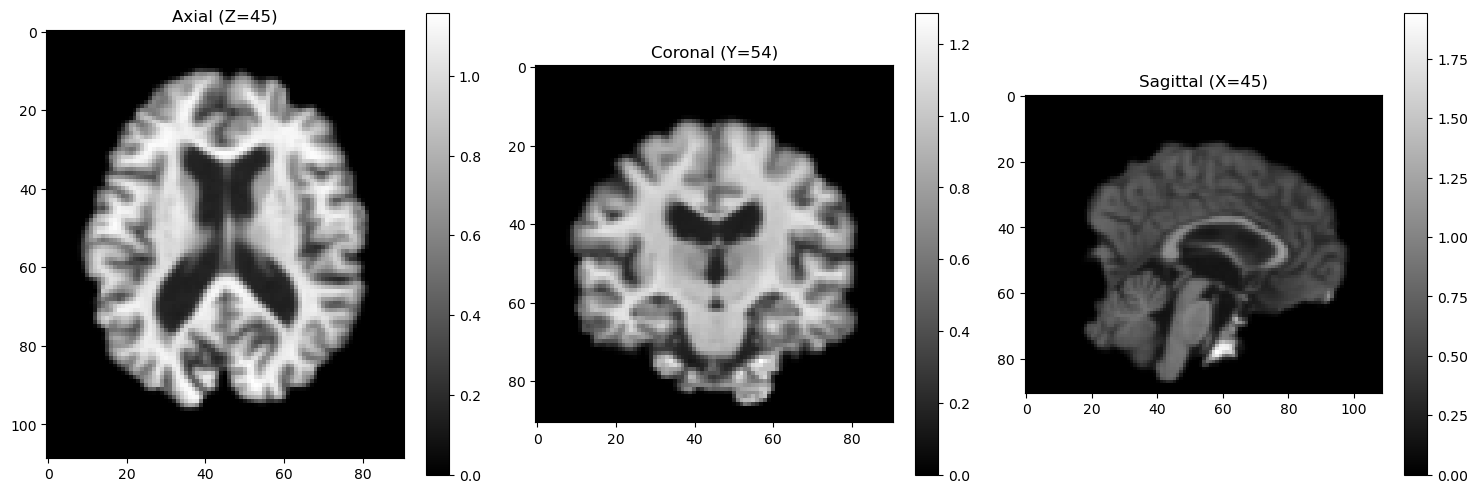

In [ ]:
# Call only when you want to see a specific scan
image_flip('oasis\\OASIS\\OAS1_0001_MR1_mpr_n4_anon_sbj_111_normalised.nii')

Orientation codes (canonical): ('R', 'A', 'S')
Image intensity range: min=0.00, max=2.47, mean=0.19


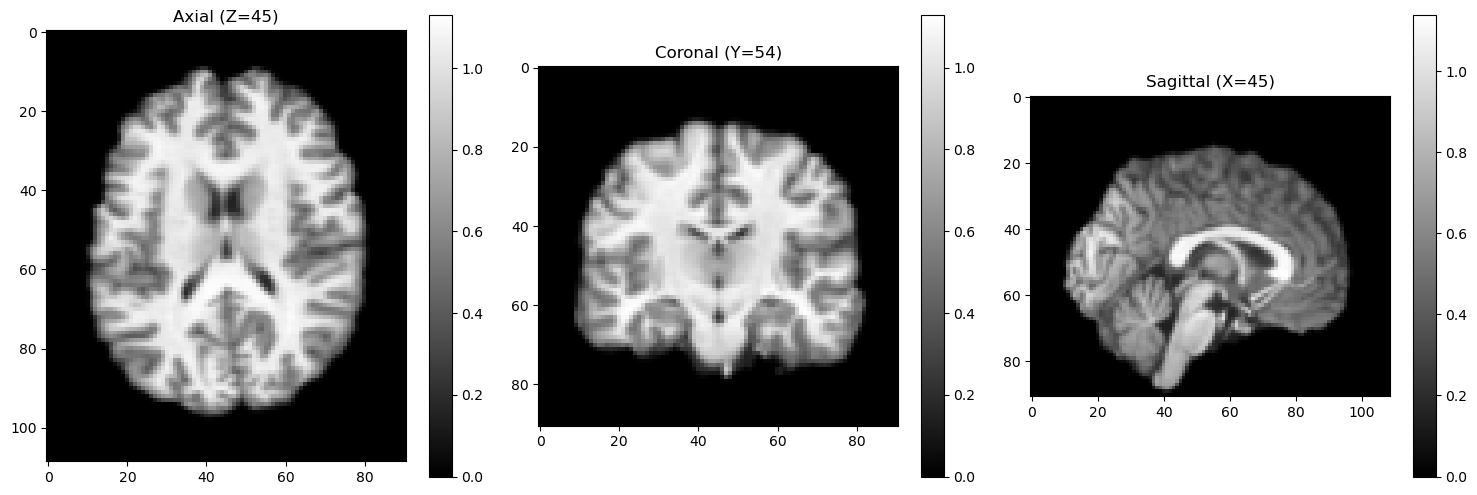

In [33]:
image_flip('oasis\\OASIS\\OAS1_0396_MR1_mpr_n4_anon_sbj_111_normalised.nii')

# Documentation: 2/2/2026 

Created image_flip() function so image flipping mri image will be easy and a function call away.

So... in the long-term, should there an added image dataset after the deployment, it will just be a continuous MLOps for training.

Next steps:
- Iterate over dataset, after splitting 80/10/10.
    - Recommendation: Split the dataset into three folders: train, test, eval
    - See: https://aravinda-gn.medium.com/how-to-split-image-dataset-into-train-validation-and-test-set-5a41c48af332
- Models: Tree-based or SVM or Boosting
- AUC/ROC - upwards 92%